In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import default_rng

rng = default_rng()

from scipy.stats import f

from nested_design_analysis import *
from dataMining_functions import *

/Users/chihoonlee/opt/anaconda3/envs/tensorflow_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# nonoverlapping window approach

# load csv files containing entropy extracted from data based on discrete wavelet transform
# slope per neuron
m = pd.read_csv('features/window512_neuron_entropy_rowwindow_Molino.csv', header=None)
p = pd.read_csv('features/window512_neuron_entropy_rowwindow_Pachon.csv', header=None)
s = pd.read_csv('features/window512_neuron_entropy_rowwindow_Surface.csv', header=None)
num_window = m.shape[0] / 16  # 16 is the number of fishes in molino group in the dataset

In [3]:
feature_name = "entropy"
m_size = [3, 11, 275, 11]

Molino's average Entropy: 6.767345992517784
Pachon's average Entropy: 6.302948651662946
Surface's average Entropy: 6.949410994067428


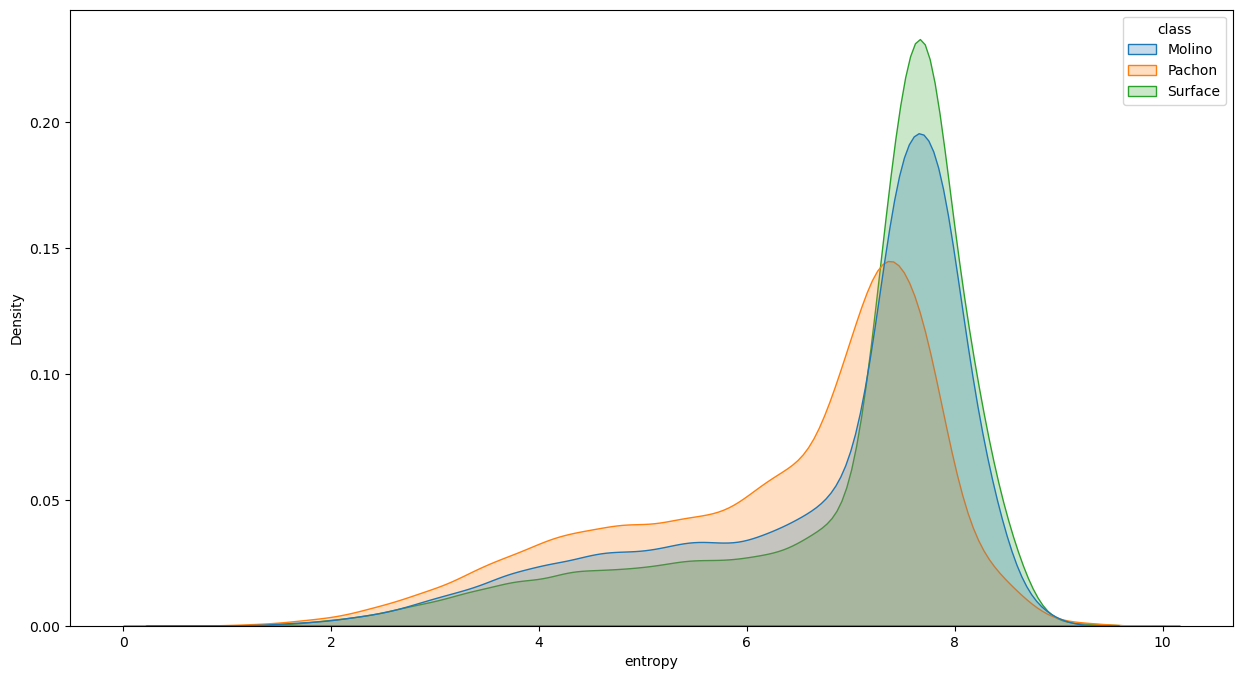

In [4]:
# set up balanced nested design and visualize KDE plot to check discriminatory power of entropy
m = m.iloc[:, :275]
p = p.iloc[:, :275]
s = s.iloc[:, :275]

# class lables: molino = 0, pachon = 1, surface = 2
m['class'] = 0
p['class'] = 1
s['class'] = 2
num_class = 3

df = pd.concat([m, p], axis=0)
df = pd.concat([df, s], axis=0)
df = balanced_nested_design_sampling(df)


# treat each entropy value from a neuron as one observation as we broke dependency with nested design
d_class = np.array(df['class'])
d_class = d_class.reshape((num_class, int(d_class.shape[0]/num_class)))
d_class = np.tile(d_class, (1, df.shape[1]-1))
d_class = d_class.flatten()
d_class = pd.DataFrame(d_class)
d_class.replace(0, 'Molino', inplace=True)
d_class.replace(1, 'Pachon', inplace=True)
d_class.replace(2, 'Surface', inplace=True)

df_flat = np.array(df.drop(labels='class', axis=1)).flatten()
df_flat.shape = df_flat.shape[0], 1
df_flat = pd.DataFrame(df_flat)
df_flat.columns = [feature_name]
df_flat['class'] = d_class

m_avg = df_flat[df_flat['class']=='Molino'][feature_name].mean()
p_avg = df_flat[df_flat['class']=='Pachon'][feature_name].mean()
s_avg = df_flat[df_flat['class']=='Surface'][feature_name].mean()
print(f"Molino's average Entropy: {m_avg}")
print(f"Pachon's average Entropy: {p_avg}")
print(f"Surface's average Entropy: {s_avg}")

# plot kernel density plots to check whether entropy has discriminating power on fish classes
plt.figure(figsize=(15,8))
sns.kdeplot(data=df_flat, x=feature_name, fill=True, hue='class')
plt.savefig(f'figures/BalancedNestedDesign_{feature_name}.png')

In [5]:
m_flat = np.array(m.drop(labels='class', axis=1)).flatten()
m_flat = pd.DataFrame(m_flat)
m_flat.columns = [feature_name]
print(f"Molino:\n{m_flat.describe()}")
print(f"Molino {feature_name} median: {m_flat.median()}")
p_flat = np.array(p.drop(labels='class', axis=1)).flatten()
p_flat = pd.DataFrame(p_flat)
p_flat.columns = [feature_name]
print(f"Pachon:\n{p_flat.describe()}")
print(f"Pachon {feature_name} median: {p_flat.median()}")
s_flat = np.array(s.drop(labels='class', axis=1)).flatten()
s_flat = pd.DataFrame(s_flat)
s_flat.columns = [feature_name]
print(f"Surface:\n{s_flat.describe()}")
print(f"Surface {feature_name} median: {s_flat.median()}")

Molino:
            entropy
count  48400.000000
mean       6.756918
std        1.509646
min        1.050045
25%        5.887961
50%        7.559461
75%        7.890684
max        8.124746
Molino entropy median: entropy    7.559461
dtype: float64
Pachon:
            entropy
count  48400.000000
mean       6.253394
std        1.638675
min        0.958194
25%        4.898022
50%        6.798851
75%        7.778268
max        8.109516
Pachon entropy median: entropy    6.798851
dtype: float64
Surface:
            entropy
count  33275.000000
mean       6.949411
std        1.464979
min        0.903349
25%        6.427285
50%        7.756053
75%        7.913708
max        8.128394
Surface entropy median: entropy    7.756053
dtype: float64


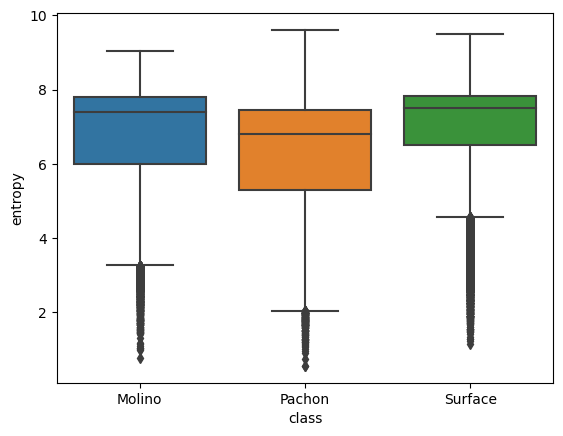

In [6]:
sns.boxplot(data=df_flat, x='class', y=feature_name)
plt.savefig(f'figures/Boxplot_{feature_name}')

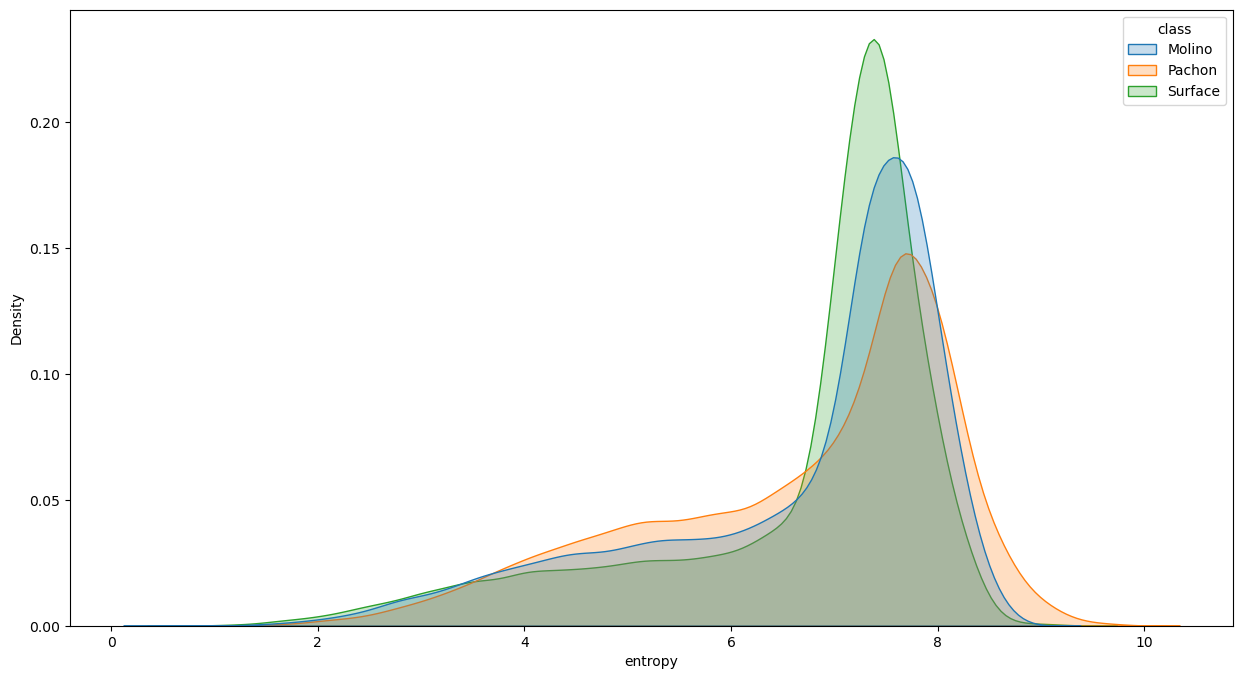

In [7]:
# subtract both Alpha_i and Beta_ji from the nested design and this leaves variability E_ijk in the equation
# plot the distribution of the variability E_ijk
df_e = pd.concat([m, p], axis=0)
df_e = pd.concat([df_e, s], axis=0)
df_e = balanced_nested_design_sampling(df_e, additional_f=True)

# treat each slope value from a neuron as one observation as we broke dependency with nested design
d_class = np.array(df_e['class'])
d_class = d_class.reshape((num_class, int(d_class.shape[0]/num_class)))
d_class = np.tile(d_class, (1, df_e.shape[1]-1))
d_class = d_class.flatten()
d_class = pd.DataFrame(d_class)
d_class.replace(0, 'Molino', inplace=True)
d_class.replace(1, 'Pachon', inplace=True)
d_class.replace(2, 'Surface', inplace=True)

df_e_flat = np.array(df_e.drop(labels='class', axis=1)).flatten()
df_e_flat.shape = df_flat.shape[0], 1
df_e_flat = pd.DataFrame(df_e_flat)
df_e_flat.columns = [feature_name]
df_e_flat['class'] = d_class


plt.figure(figsize=(15,8))
sns.kdeplot(data=df_e_flat, x=feature_name, fill=True, hue='class')
plt.savefig(f'figures/BalancedNestedDesign_Eijk_{feature_name}.png')